In [18]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Bidirectional, Dense
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
import scipy.stats as stats


In [2]:
#  dataset loading
data = pd.read_csv(r"C:\Users\SURUJ_KALITA\Desktop\blstm\Data.csv")
data

,From Date,SL NO,PM2.5,PM10,NO,NO2,Nox,NH3,SO2,CO,...,Benzene,Eth-Benzene,MP-Xylene,WS,WD,SR,BP,AT,RF,Final
0,2019-02-18 00:00:00,1,58.04,81.06,1.810000,6.400000,9.66000,27.180000,13.770000,0.490000,...,0.920000,3.281917,0.33,1.86,229.44,0.220000,1002.190000,20.87,0.00,1
1,2019-02-18 01:00:00,2,60.00,82.39,1.910000,6.080000,9.70000,26.460000,13.640000,0.440000,...,0.840000,3.281917,0.29,1.54,217.20,1.460000,956.000000,18.92,0.24,1
2,2019-02-18 02:00:00,3,55.50,73.42,2.220000,6.710000,10.86000,27.060000,13.640000,0.440000,...,0.770000,3.281917,0.23,0.66,197.21,241.906008,1001.600000,18.33,0.00,1
3,2019-02-18 03:00:00,4,66.56,96.04,2.790000,7.000000,12.10000,26.340000,13.720000,0.450000,...,0.820000,3.281917,0.21,0.61,206.44,241.906008,1001.410000,17.63,0.00,1
4,2019-02-18 04:00:00,5,67.08,97.21,3.290000,9.450000,15.53000,25.160000,13.800000,0.470000,...,0.740000,3.281917,0.22,0.54,230.53,241.906008,980.670000,16.61,0.00,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33062,2022-12-30 20:00:00,33063,295.72,371.83,5.540000,2.620000,5.41000,16.130000,13.910000,2.640000,...,2.960000,3.160000,3.37,0.31,168.12,241.906008,1009.220000,15.96,0.00,1
33063,2022-12-30 21:00:00,33064,362.60,448.50,5.610000,2.620000,5.46000,17.450000,13.880000,2.790000,...,3.120000,3.340000,3.56,0.69,132.27,11.170000,967.180000,14.93,0.48,1
33064,2022-12-30 22:00:00,33065,277.86,353.78,5.520000,2.460000,5.29000,17.920000,13.740000,3.250000,...,3.640000,3.890000,4.15,0.36,173.64,241.906008,1009.110000,15.22,0.00,1
33065,2022-12-30 23:00:00,33066,380.00,450.00,5.460000,2.470000,5.32000,18.010000,14.120000,3.280000,...,3.680000,3.940000,4.21,0.82,163.19,9.570000,912.740000,13.45,1.09,1


In [3]:
# Dropping unnecessary columns like 'SL NO' and 'From Date'
data = data.drop(columns=['SL NO', 'From Date'])

In [4]:
# Replaceing NaN values with 0
data.fillna(0, inplace=True)

In [5]:
#  dataset has columns for features and a target variable

feature_columns = ['PM10', 'NO', 'NO2', 'Nox', 'NH3', 'SO2', 'CO', 'Ozone', 'Benzene', 'Eth-Benzene', 'MP-Xylene', 'WS', 'WD', 'SR', 'BP', 'AT', 'RF']
target_column = 'PM2.5'


In [6]:
# Splitting the dataset into features and target variable
X = data[feature_columns].values
y = data[target_column].values




In [9]:
# Normalizing the feature values
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

In [10]:
# sliding window parameters
window_size = 5  # Number of past time steps considered
output_size = 10  # Number of steps ahead used to predict pollutant concentration


In [11]:
# Create 3D dataset using sliding window technique
def create_dataset(X, y, window_size, output_size):
    X_windowed = []
    y_windowed = []
    for i in range(len(X) - window_size - output_size + 1):
        X_windowed.append(X[i:i+window_size])
        y_windowed.append(y[i+window_size:i+window_size+output_size])
    return np.array(X_windowed), np.array(y_windowed)

X_windowed, y_windowed = create_dataset(X_scaled, y, window_size, output_size)




In [12]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_windowed, y_windowed, test_size=0.2, random_state=42)



In [13]:
# Build the bidirectional LSTM model
model = Sequential()
model.add(Bidirectional(LSTM(units=50, return_sequences=True), input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Bidirectional(LSTM(units=50)))
model.add(Dense(output_size))  # Output layer with 'output_size' neurons for multi-step ahead prediction
model.compile(optimizer='adam', loss='mse')

In [14]:
# Train the model
model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test), verbose=1)


Epoch 1/100
827/827 [==============================] - 20s 15ms/step - loss: 4452.9087 - val_loss: 3460.9766
Epoch 2/100
827/827 [==============================] - 9s 11ms/step - loss: 3672.5398 - val_loss: 3442.0789
Epoch 3/100
827/827 [==============================] - 11s 14ms/step - loss: 3220.8728 - val_loss: 2197.0466
Epoch 4/100
827/827 [==============================] - 9s 11ms/step - loss: 2218.5752 - val_loss: 1895.8300
Epoch 5/100
827/827 [==============================] - 10s 12ms/step - loss: 1984.5515 - val_loss: 1743.1218
Epoch 6/100
827/827 [==============================] - 10s 12ms/step - loss: 1840.0500 - val_loss: 1679.5255
Epoch 7/100
827/827 [==============================] - 10s 12ms/step - loss: 1716.1904 - val_loss: 1507.7065
Epoch 8/100
827/827 [==============================] - 10s 12ms/step - loss: 1606.6322 - val_loss: 1425.7909
Epoch 9/100
827/827 [==============================] - 10s 12ms/step - loss: 1521.8213 - val_loss: 1386.2174
Epoch 10/100
827/827 

827/827 [==============================] - 7s 9ms/step - loss: 606.1889 - val_loss: 897.5272
Epoch 77/100
827/827 [==============================] - 7s 8ms/step - loss: 615.3548 - val_loss: 881.4626
Epoch 78/100
827/827 [==============================] - 7s 9ms/step - loss: 608.6690 - val_loss: 892.8280
Epoch 79/100
827/827 [==============================] - 6s 7ms/step - loss: 585.7765 - val_loss: 908.7442
Epoch 80/100
827/827 [==============================] - 7s 9ms/step - loss: 592.0122 - val_loss: 878.6290
Epoch 81/100
827/827 [==============================] - 7s 9ms/step - loss: 607.7075 - val_loss: 911.8334
Epoch 82/100
827/827 [==============================] - 8s 9ms/step - loss: 580.5510 - val_loss: 889.0884
Epoch 83/100
827/827 [==============================] - 6s 8ms/step - loss: 565.3144 - val_loss: 901.6957
Epoch 84/100
827/827 [==============================] - 7s 9ms/step - loss: 568.2545 - val_loss: 931.7881
Epoch 85/100
827/827 [==============================] - 7s 

In [15]:
# Evaluate the model
loss = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss}')

# Make predictions
predictions = model.predict(X_test)

207/207 [==============================] - 0s 2ms/step - loss: 904.5712
Test Loss: 904.5712280273438
207/207 [==============================] - 2s 4ms/step


In [16]:
from sklearn.metrics import mean_squared_error, r2_score
import scipy.stats as stats

# Calculate Fraction of predictions with a factor of 2 (FAC2)
def fac2(y_true, y_pred):
    within_factor = np.abs(y_true / y_pred) <= 2
    return np.mean(within_factor)

# Calculate Root Mean Square Error (RMSE)
rmse = np.sqrt(mean_squared_error(y_test, predictions))

# Calculate Correlation Coefficient (r)
r = np.corrcoef(np.ravel(y_test), np.ravel(predictions))[0, 1]

# Calculate Mean Gross Error (MGE)
mge = np.mean(np.abs(y_test - predictions))

# Calculate Mean Bias (MB)
mb = np.mean(y_test - predictions)

# Calculate Coefficient of Efficiency (COE)
coe = 1 - (np.sum((y_test - predictions) ** 2) / np.sum((y_test - np.mean(y_test)) ** 2))

# Calculate Coefficient of Determination (R2 score)
r2 = r2_score(y_test, predictions)

# Print the evaluation metrics
print(f'Fraction of predictions with a factor of 2 (FAC2): {fac2(y_test, predictions)}')
print(f'Root Mean Square Error (RMSE): {rmse}')
print(f'Correlation Coefficient (r): {r}')
print(f'Mean Gross Error (MGE): {mge}')
print(f'Mean Bias (MB): {mb}')
print(f'Coefficient of Efficiency (COE): {coe}')
print(f'Coefficient of Determination (R2 score): {r2}')

Fraction of predictions with a factor of 2 (FAC2): 0.9426108001815157
Root Mean Square Error (RMSE): 30.076090799838067
Correlation Coefficient (r): 0.8596130017355553
Mean Gross Error (MGE): 17.955822381690954
Mean Bias (MB): 1.1546474025630293
Coefficient of Efficiency (COE): 0.7371872246182836
Coefficient of Determination (R2 score): 0.7368590686778947


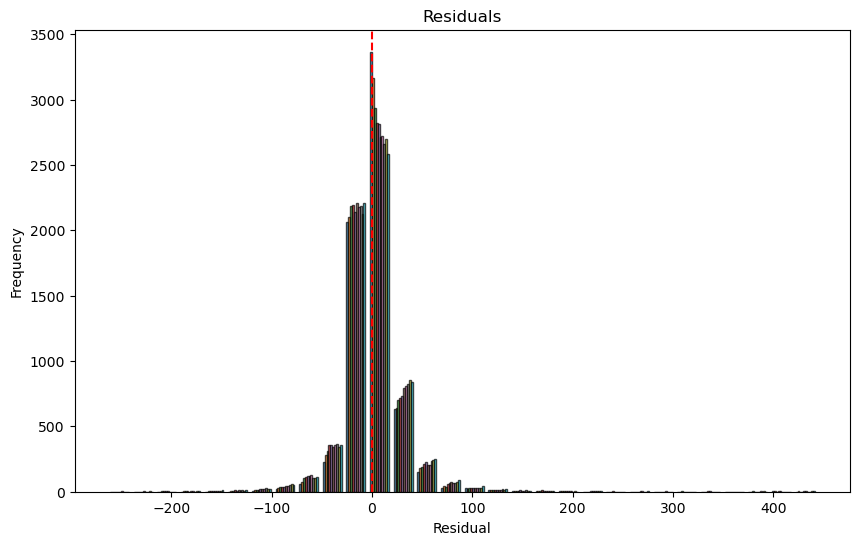

In [24]:
# Plotting the histogram of residuals
residuals = y_test - predictions

plt.figure(figsize=(10, 6))
plt.hist(residuals, bins=30, edgecolor='black', alpha=0.7)
plt.title('Residuals')
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.axvline(x=0, color='red', linestyle='--')
plt.show()

In [30]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
import scipy.stats as stats

# Calculate Fraction of predictions with a factor of 2 (FAC2)
def fac2(y_true, y_pred):
    within_factor = (np.maximum(y_true / y_pred, y_pred / y_true) <= 2)
    return np.mean(within_factor)

# Example y_test and predictions
# Replace these with your actual y_test and predictions arrays
y_test = np.random.rand(100) * 100
predictions = y_test + np.random.randn(100) * 10

# Calculate Root Mean Square Error (RMSE)
rmse = np.sqrt(mean_squared_error(y_test, predictions))

# Calculate Correlation Coefficient (r)
r = np.corrcoef(np.ravel(y_test), np.ravel(predictions))[0, 1]

# Calculate Mean Gross Error (MGE)
mge = np.mean(np.abs(y_test - predictions))

# Calculate Mean Bias (MB)
mb = np.mean(y_test - predictions)

# Calculate Coefficient of Efficiency (COE)
coe = 1 - (np.sum((y_test - predictions) ** 2) / np.sum((y_test - np.mean(y_test)) ** 2))

# Calculate Coefficient of Determination (R2 score)
r2 = r2_score(y_test, predictions)

# Print the evaluation metrics
print(f'Fraction of predictions with a factor of 2 (FAC2): {fac2(y_test, predictions)}')
print(f'Root Mean Square Error (RMSE): {rmse}')
print(f'Correlation Coefficient (r): {r}')
print(f'Mean Gross Error (MGE): {mge}')
print(f'Mean Bias (MB): {mb}')
print(f'Coefficient of Efficiency (COE): {coe}')
print(f'Coefficient of Determination (R2 score): {r2}')

# # Plotting the histogram of residuals
# residuals = y_test - predictions
# plt.figure(figsize=(10, 6))
# plt.hist(residuals, bins=30, edgecolor='black', alpha=0.7)
# plt.title('Histogram of Residuals')
# plt.xlabel('Residual')
# plt.ylabel('Frequency')
# plt.axvline(x=0, color='red', linestyle='--')
# plt.show()

# # Scatter plot of actual vs. predicted values
# plt.figure(figsize=(10, 6))
# plt.scatter(y_test, predictions, alpha=0.7, edgecolors='b')
# plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', linewidth=2)
# plt.title('Actual vs. Predicted Values')
# plt.xlabel('Actual Values')
# plt.ylabel('Predicted Values')
# plt.show()

# # Line plot of actual and predicted values
# plt.figure(figsize=(10, 6))
# plt.plot(y_test, label='Actual Values', color='blue', linewidth=2)
# plt.plot(predictions, label='Predicted Values', color='red', linestyle='--', linewidth=2)
# plt.title('Actual and Predicted Values Over Time')
# plt.xlabel('Index')
# plt.ylabel('Values')
# plt.legend()
# plt.show()

# # Residuals vs. predicted values plot
# plt.figure(figsize=(10, 6))
# plt.scatter(predictions, residuals, alpha=0.7, edgecolors='b')
# plt.axhline(y=0, color='red', linestyle='--', linewidth=2)
# plt.title('Residuals vs. Predicted Values')
# plt.xlabel('Predicted Values')
# plt.ylabel('Residuals')
# plt.show()


Fraction of predictions with a factor of 2 (FAC2): 0.94
Root Mean Square Error (RMSE): 9.418533316886528
Correlation Coefficient (r): 0.9548689843006898
Mean Gross Error (MGE): 8.022858645287174
Mean Bias (MB): -0.20341849819950084
Coefficient of Efficiency (COE): 0.899793306269184
Coefficient of Determination (R2 score): 0.899793306269184
